In [1]:
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import re
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from catboost import Pool, CatBoostClassifier

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
from statsmodels.stats.proportion import proportion_confint
import tensorflow as tf
from tensorflow import keras

## **P2P Lending Solution: Judgement of Loans, Grading Customers, Set of Interest rate**

## Introduction to P2P Lending Solution
<hr>
    <div style="width:70%"><img src="https://timgsa.baidu.com/timg?image&quality=80&size=b9999_10000&sec=1589981211436&di=7e11ff59da692910aaa9c28c172fe1ff&imgtype=0&src=http%3A%2F%2Fimgbdb3.bendibao.com%2Fszbdb%2F20188%2F10%2F2018810164929_40217.jpg"/></div>

Peer-to-peer lending (P2P), is a practice of lending money to individuals or businesses through online services that match lenders with borrowers. P2P lending company earns a profit from providing the match-making platform and setting interests.

However, from 2014 to 2019, there is a large number of defaulting cases occurred in P2P business, which always raises severe financial storms in P2P industry. And the main reason is the immaturity of credit investigation system and the miscalculation of credits. 

So, given there is a large risk on credit investigation system, we decide to create algorithms on **the judgement of loans, grading customers and set of interest rate** to solve P2P risk on individual level.


# EDA

# Deal with data

In [51]:
df = pd.read_csv('accepted_2007_to_2018Q4.csv', low_memory=False)
original_df = df.copy()

In [52]:
df = df[["loan_amnt", "term", "int_rate", "grade", "home_ownership", "annual_inc", "verification_status",
       "issue_d", "loan_status", "purpose", "addr_state"]]
#Here we get some categories for EDA

In [53]:
df.head()

,loan_amnt,term,int_rate,grade,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state
0,2500,36 months,13.56,C,RENT,55000.0,Not Verified,Dec-2018,Current,debt_consolidation,NY
1,30000,60 months,18.94,D,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,debt_consolidation,LA
2,5000,36 months,17.97,D,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,debt_consolidation,MI
3,4000,36 months,18.94,D,MORTGAGE,92000.0,Source Verified,Dec-2018,Current,debt_consolidation,WA
4,30000,60 months,16.14,C,MORTGAGE,57250.0,Not Verified,Dec-2018,Current,debt_consolidation,MD


In [54]:
Object_term = original_df.columns[(original_df.dtypes == 'object').values]
df_int = original_df.drop(Object_term, axis=1)
# Here we get some numeric data for corelation research and training later.

In [55]:
df_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 109 entries, id to settlement_term
dtypes: float64(105), int64(4)
memory usage: 1.8 GB


In [56]:
df.isnull().sum()

loan_amnt              0
term                   0
int_rate               0
grade                  0
home_ownership         0
annual_inc             4
verification_status    0
issue_d                0
loan_status            0
purpose                0
addr_state             0
dtype: int64

In [57]:
df = df.rename(columns={"loan_amnt": "loan_amount", "int_rate": "interest_rate", "annual_inc": "annual_income"})

# Interest rate distribution

In [58]:
df['int_round'] = df['interest_rate'].round(0).astype(int)

(0, 141541.40000000002)

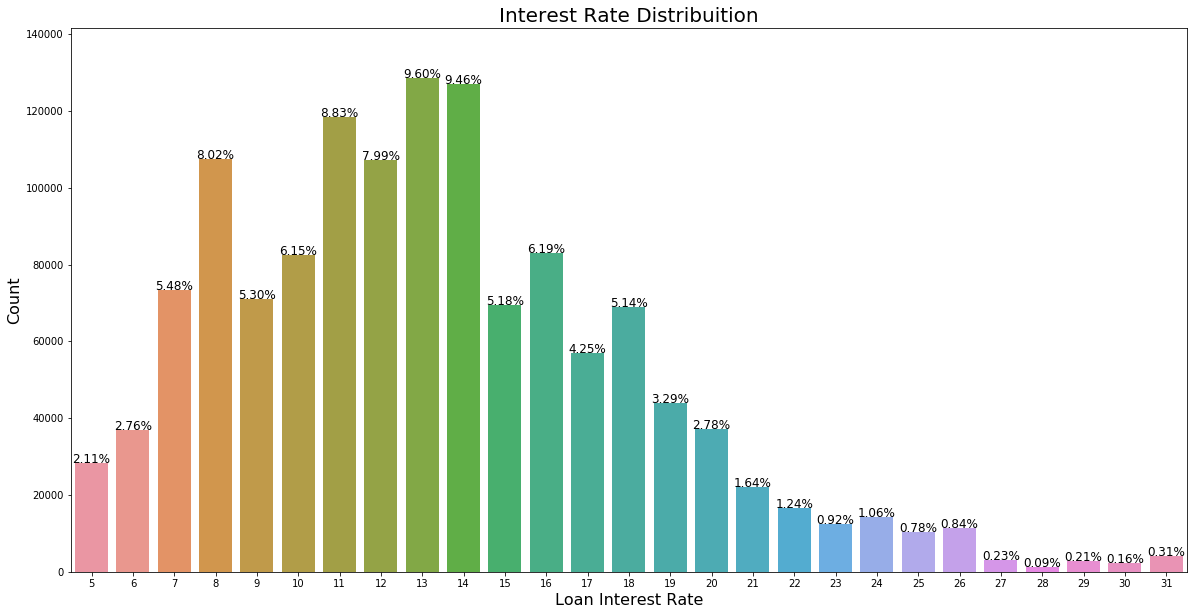

In [45]:
plt.figure(figsize=(20,10))
g = sns.countplot(x="int_round", data=df)
g.set_xlabel("Loan Interest Rate", fontsize=16)
g.set_ylabel("Count", fontsize=16)
g.set_title("Interest Rate Distribuition", fontsize=20)
sizes=[] # Get highest values in y
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 6,
            '{:1.2f}%'.format(height/len(df)*100),
            ha="center", fontsize=12) 
g.set_ylim(0, max(sizes) * 1.10)

# Loan condition

In [59]:
df_2=df.copy()

In [61]:
df.drop(df[df.loan_condition=='Current'].index, inplace=True)

In [70]:
bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]
Current = ["Current"]

df['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 'Bad_Loan'
    elif status in Current:
        return 'Current'
    else:
        return 'Good_Loan'

df['loan_condition'] = df['loan_status'].apply(loan_condition)

In [20]:
by_credit_score = df.groupby(['loan_condition'], as_index=False).loan_amount.sum()
by_credit_score.sort_index(axis=0, ascending=False, inplace=True)

(0, 16217278330.000002)

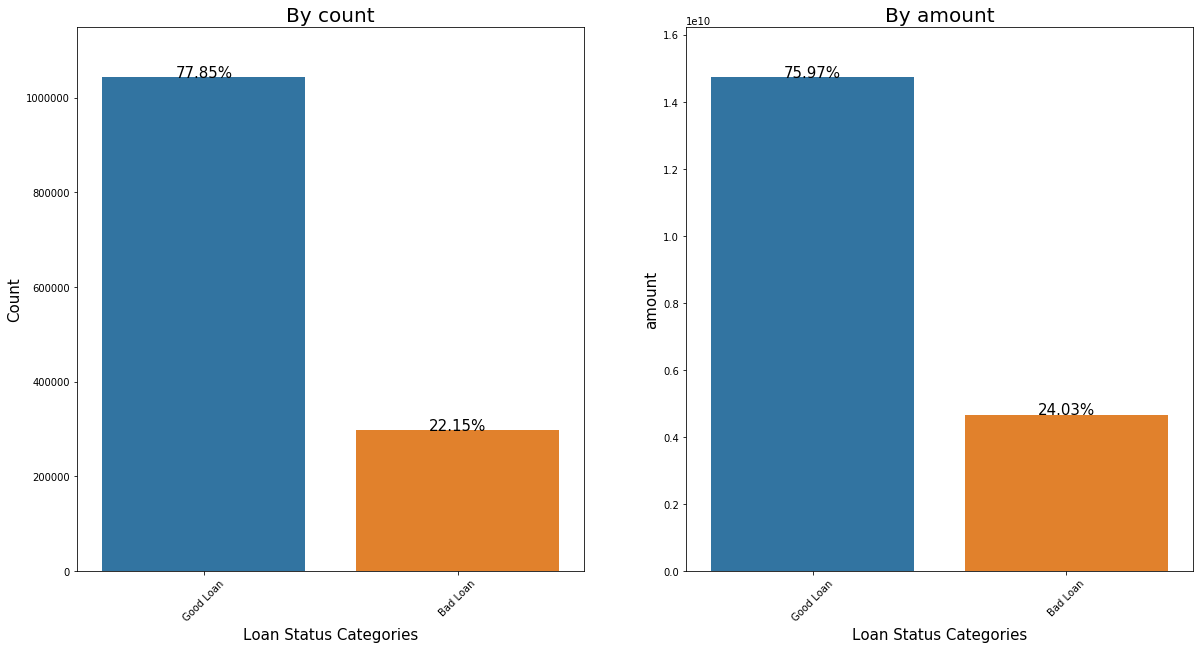

In [21]:
plt.figure(figsize=(10*2,10))
plt.subplot(121)
g1 = sns.countplot(x="loan_condition", data=df)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("Loan Status Categories", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
g1.set_title("By count", fontsize=20)
sizes=[]
for i in g1.patches:
    height = i.get_height()
    sizes.append(height)
    g1.text(i.get_x()+i.get_width()/2.,
            height + 5,
            '{:1.2f}%'.format(height/len(df)*100),
            ha="center", fontsize=15) 
g1.set_ylim(0, max(sizes) * 1.10)


plt.subplot(122)
g1 = sns.barplot(x="loan_condition", y="loan_amount",data=by_credit_score)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("Loan Status Categories", fontsize=15)
g1.set_ylabel("amount", fontsize=15)
g1.set_title("By amount", fontsize=20)
sizes=[]
for i in g1.patches:
    height = i.get_height()
    sizes.append(height)
    g1.text(i.get_x()+i.get_width()/2.,
            height + 5,
            '{:1.2f}%'.format(height/sum(by_credit_score.loan_amount)*100),
            ha="center", fontsize=15) 
g1.set_ylim(0, max(sizes) * 1.10)

# Datetime

In [63]:
df['issue_d'].head()
dt_series = pd.to_datetime(df['issue_d'])
df['year'] = dt_series.dt.year
df['month'] = dt_series.dt.month

Text(0.5, 1.0, 'Loan amount each month by conditions')

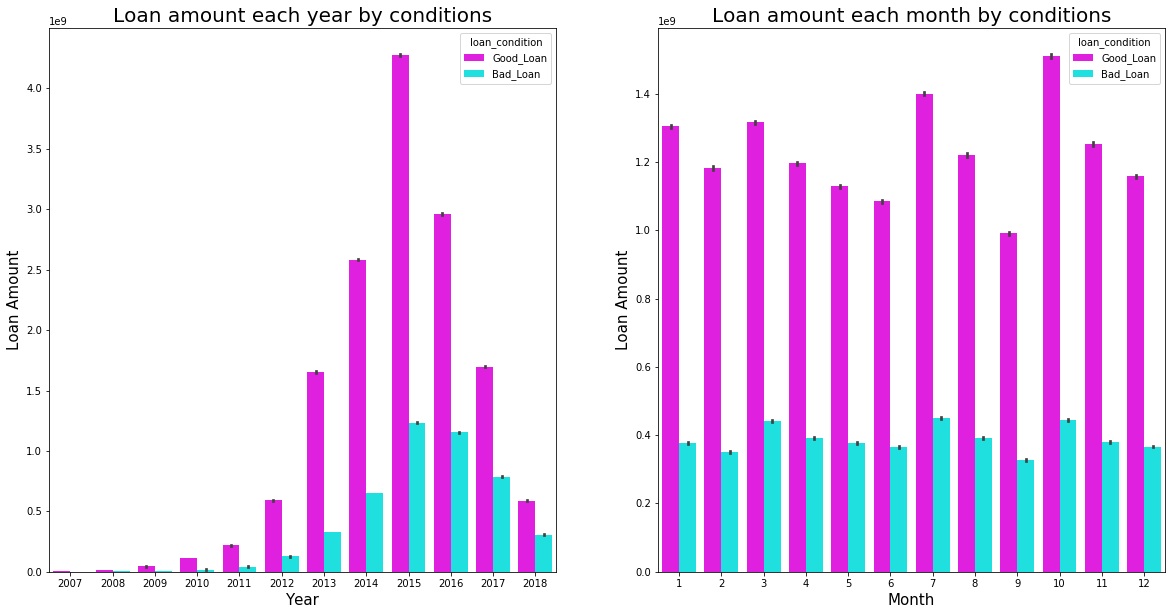

In [77]:
pal = dict(Bad_Loan="#00FFFF", Good_Loan="#FF00FF")
plt.figure(figsize=(20,10))
plt.subplot(121)
g1 = sns.barplot(x="year", y="loan_amount", hue="loan_condition", data=df,
            estimator=lambda x: x.sum(), palette=pal)
g1.set_xlabel("Year", fontsize=15)
g1.set_ylabel("Loan Amount", fontsize=15)
g1.set_title("Loan amount each year by conditions", fontsize=20)

plt.subplot(122)
g2 = sns.barplot(x="month", y="loan_amount", hue="loan_condition", data=df,
            estimator=lambda x: x.sum(), palette=pal)
g2.set_xlabel("Month", fontsize=15)
g2.set_ylabel("Loan Amount", fontsize=15)
g2.set_title("Loan amount each month by conditions", fontsize=20)

(0, 4701542367.5)

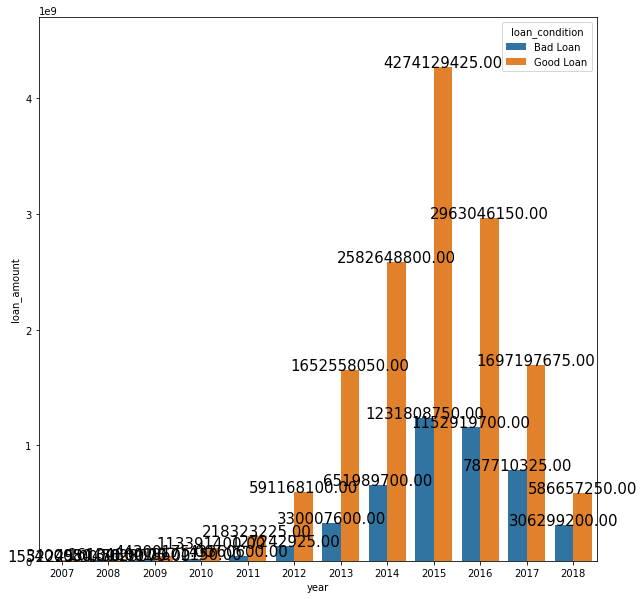

In [173]:
test = df.groupby(["year", 'loan_condition'], as_index=False).loan_amount.sum()
plt.figure(figsize=(10,10))
g1 = sns.barplot(x="year", y="loan_amount", hue = "loan_condition", data = test, estimator = lambda x: x.sum())
for i in g1.patches:
    height = i.get_height()
    sizes.append(height)
    g1.text(i.get_x()+i.get_width()/2.,
            height + 5,
            '{:1.2f}'.format(height),
            ha="center", fontsize=15) 
g1.set_ylim(0, max(sizes) * 1.10)

# Region

In [78]:
df['addr_state'].unique()

array(['CA', 'OH', 'WA', 'TX', 'MA', 'PA', 'MI', 'ID', 'AZ', 'NY', 'LA',
       'RI', 'IL', 'TN', 'NV', 'MN', 'NM', 'NJ', 'CO', 'VA', 'NC', 'FL',
       'KY', 'OK', 'CT', 'MD', 'NH', 'IN', 'GA', 'AL', 'MT', 'SC', 'DC',
       'OR', 'NE', 'KS', 'HI', 'AK', 'VT', 'MO', 'UT', 'AR', 'MS', 'WI',
       'ND', 'DE', 'WV', 'ME', 'SD', 'WY', 'IA'], dtype=object)

In [79]:
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    
df['region'] = df['addr_state'].apply(finding_regions)

In [80]:
df["issue_date"] = pd.to_datetime(df['issue_d']).dt.to_period("M")

In [81]:
interest_by_region = df.groupby(['region'], as_index=False).interest_rate.mean()

In [82]:
interest_by_region["interest_rate"] -= 13

(0, 0.4828913079970621)

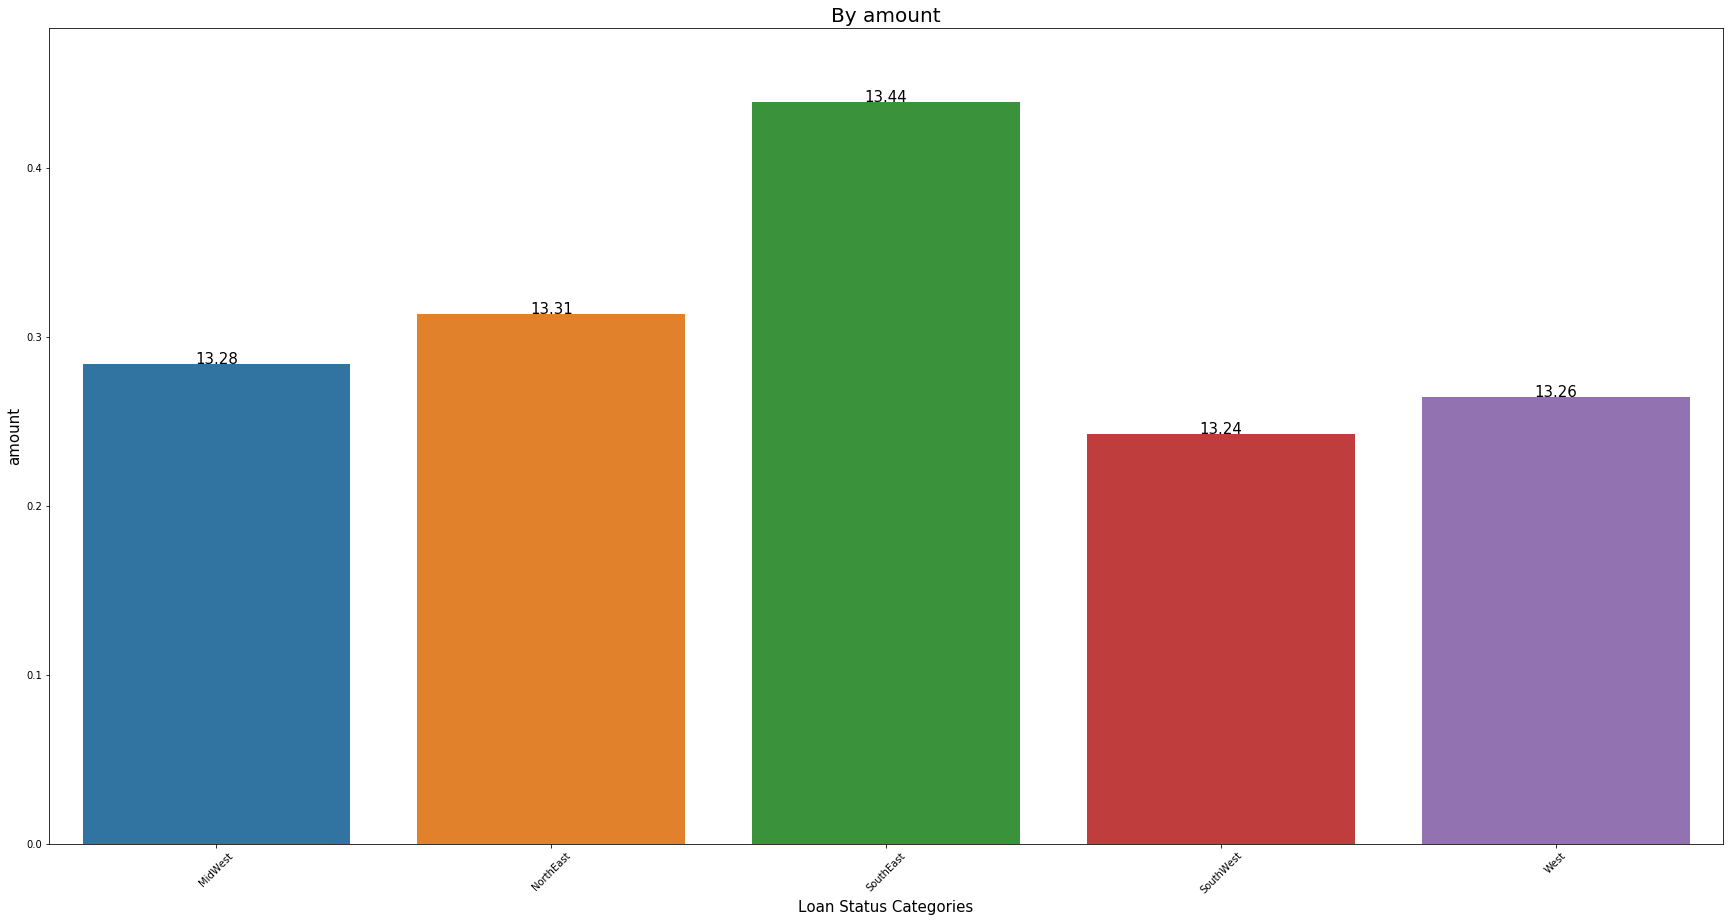

In [83]:
plt.figure(figsize=(30,15))
g1 = sns.barplot(x="region", y="interest_rate",data=interest_by_region)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("Loan Status Categories", fontsize=15)
g1.set_ylabel("amount", fontsize=15)
g1.set_title("By amount", fontsize=20)
sizes=[]
for i in g1.patches:
    height = i.get_height()
    sizes.append(height)
    g1.text(i.get_x()+i.get_width()/2.,
            height,
            '{:1.2f}'.format(height+13),
            ha="center", fontsize=15) 
g1.set_ylim(0, max(sizes) * 1.10)

In [84]:
group_dates = df.groupby(['issue_date', 'region'], as_index=False).sum()
df_dates = pd.DataFrame(data=group_dates[['issue_date','region','loan_amount']])

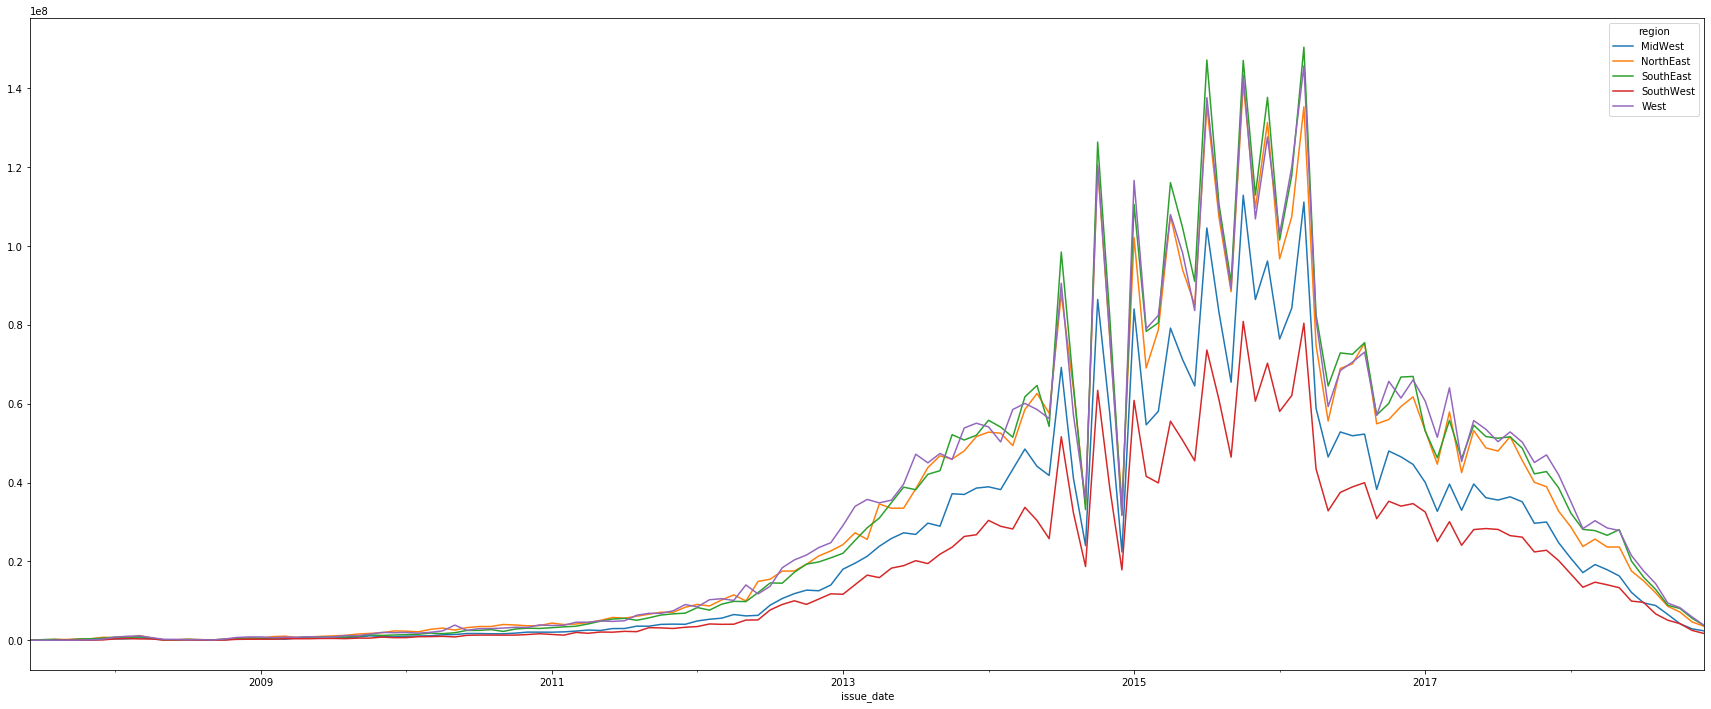

In [85]:
loans_by_region = df.groupby(['issue_date', 'region']).loan_amount.sum()
loans_by_region.unstack().plot( grid=False, figsize=(30,12))

In [129]:
df.groupby("region")["loan_amount"].sum()

region
MidWest      3283514950
NorthEast    4428318450
SouthEast    4621887400
SouthWest    2408275700
West         4665063300
Name: loan_amount, dtype: int64

Text(0.5, 1.0, 'Loan amount each region by conditions (Percentage)')

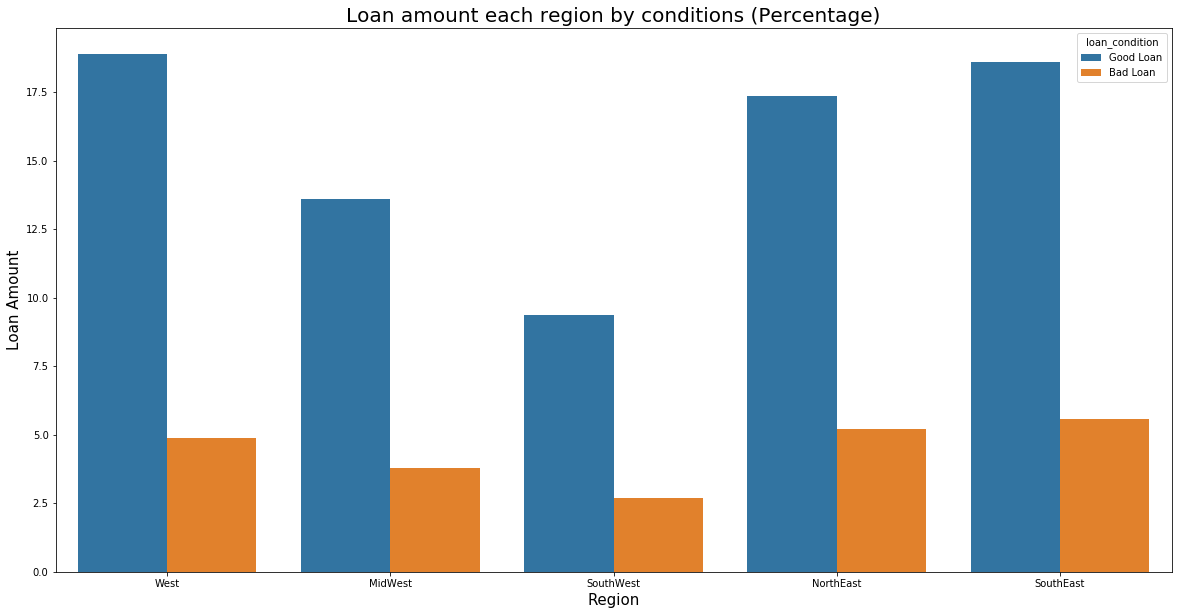

In [131]:
plt.figure(figsize=(20,10))
g2 = sns.barplot(x="region", y="loan_amount", hue="loan_condition", data=df,
            estimator=lambda x: len(x) / len(df) * 100, )
g2.set_xlabel("Region", fontsize=15)
g2.set_ylabel("Loan Amount", fontsize=15)
g2.set_title("Loan amount each region by conditions (Percentage)", fontsize=20)

# Income

In [86]:
df["annual_income"].mean()

76196.18644806107

In [87]:
df["income_category"] = pd.cut(df["annual_income"],
                               bins=[0, 24000, 54000, np.inf],
                               labels=['low salary', 'medium salary', 'high salary'])

'temp = df.groupby(["income_category"], as_index = False).loan_amount.sum()\nplt.subplot(122)\ng2 = sns.barplot(x="income_category", y="loan_amount", data=temp)\ng2.set_xlabel("Income", fontsize=15)\ng2.set_ylabel("Loan Amount", fontsize=15)\ng2.set_title("By amount", fontsize=20)'

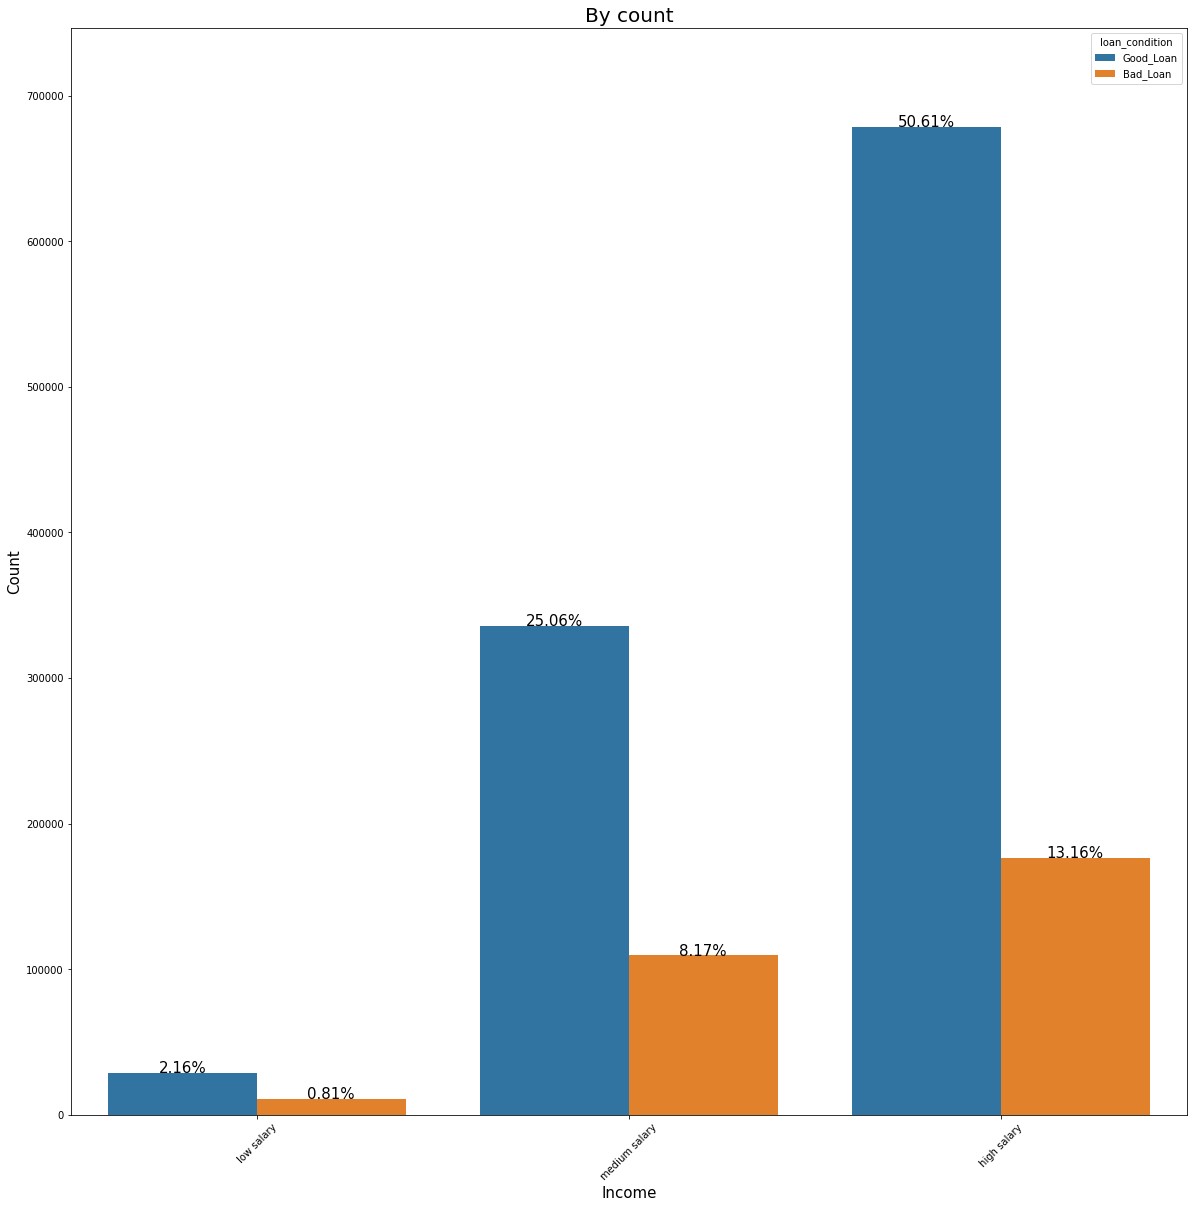

In [88]:
plt.figure(figsize=(20,20))

g1 = sns.countplot(x="income_category", hue="loan_condition", data=df)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("Income", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
g1.set_title("By count", fontsize=20)
sizes=[]
for i in g1.patches:
    height = i.get_height()
    sizes.append(height)
    g1.text(i.get_x()+i.get_width()/2.,
            height + 5,
            '{:1.2f}%'.format(height/len(df)*100),
            ha="center", fontsize=15) 
g1.set_ylim(0, max(sizes) * 1.10)

'''temp = df.groupby(["income_category"], as_index = False).loan_amount.sum()
plt.subplot(122)
g2 = sns.barplot(x="income_category", y="loan_amount", data=temp)
g2.set_xlabel("Income", fontsize=15)
g2.set_ylabel("Loan Amount", fontsize=15)
g2.set_title("By amount", fontsize=20)'''

# Grade

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

loans_by_region = df.groupby(['grade', 'loan_condition']).size()
loans_by_region.unstack().plot(kind='bar', stacked=True, ax = ax1, grid=False)
ax1.set_title('Type of Loans by Grade(Count)', fontsize=14)

loans_by_region_sum = df.groupby(['grade', 'loan_condition'])["loan_amount"].sum()
loans_by_region_sum.unstack().plot(kind='bar', stacked=True, ax = ax2, grid=False)
ax2.set_title('Type of Loans by Grade(sum)', fontsize=14)

In [148]:
loans_by_region_sum = df.groupby(['grade', 'loan_condition'])["loan_amount"].sum()

In [149]:
loans_by_region_sum = loans_by_region_sum.to_frame()

In [150]:
loans_by_region_sum["proportion"] = loans_by_region_sum['loan_amount']/loans_by_region_sum['loan_amount'].sum()*100

In [151]:
loans_by_region_sum

loan_amount  proportion
grade loan_condition                         
A     Bad Loan          224600500    1.157313
      Good Loan        2951124875   15.206450
B     Bad Loan          812155200    4.184844
      Good Loan        4339341975   22.359605
C     Bad Loan         1431723625    7.377334
      Good Loan        4023616525   20.732747
D     Bad Loan         1086760525    5.599821
      Good Loan        2034266925   10.482097
E     Bad Loan          705540800    3.635485
      Good Loan         976666225    5.032531
F     Bad Loan          302254900    1.557448
      Good Loan         323840775    1.668675
G     Bad Loan          101069150    0.520785
      Good Loan          94097800    0.484864

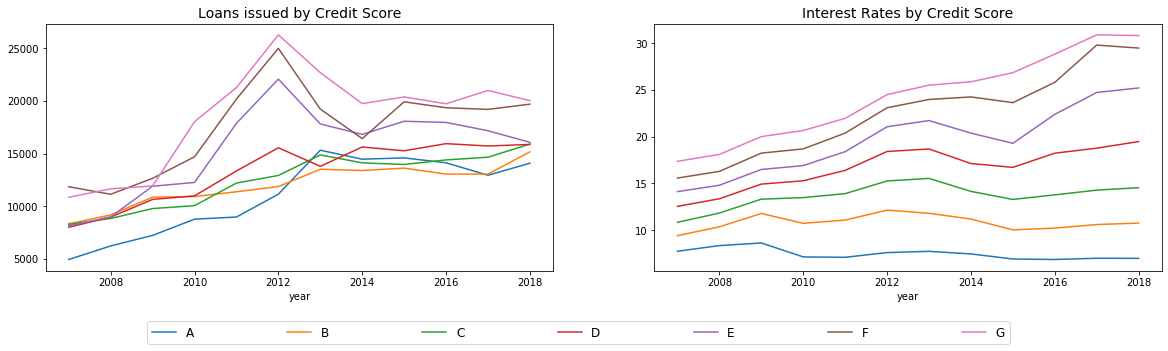

In [152]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

by_credit_score = df.groupby(['year', 'grade']).loan_amount.mean()
by_credit_score.unstack().plot(legend=False, ax=ax1)
ax1.set_title('Loans issued by Credit Score', fontsize=14)
    
    
by_inc = df.groupby(['year', 'grade']).interest_rate.mean()
by_inc.unstack().plot(ax=ax2)
ax2.set_title('Interest Rates by Credit Score', fontsize=14)

ax2.legend(bbox_to_anchor=(-1.0, -0.3, 1.7, 0.1), loc=5, prop={'size':12},
           ncol=7, mode="expand", borderaxespad=0.)

Text(0, 0.5, 'Interest Rate (%)')

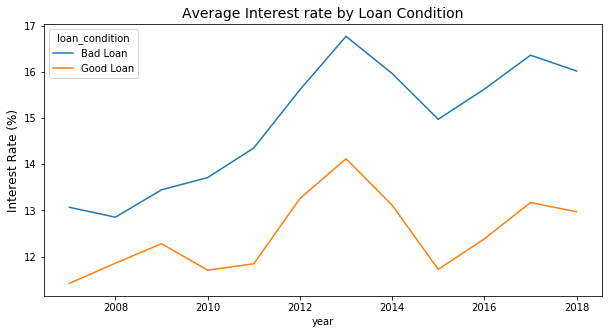

In [155]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

by_interest = df.groupby(['year', 'loan_condition']).interest_rate.mean()
by_interest.unstack().plot(ax=ax1)
ax1.set_title('Average Interest rate by Loan Condition', fontsize=14)
ax1.set_ylabel('Interest Rate (%)', fontsize=12)

# Purpose

'\nplt.subplot(313)\ng3 = sns.barplot(x="purpose", y="loan_amount", hue="loan_condition", data=df,\n            estimator=lambda x: np.log(x.sum()))\ng3.set_xlabel("Purpose", fontsize=15)\ng3.set_ylabel("Interest rate(Logarithm)", fontsize=15)\ng3.set_title("Loan condition of each purpose (Logarithm)", fontsize=20)'

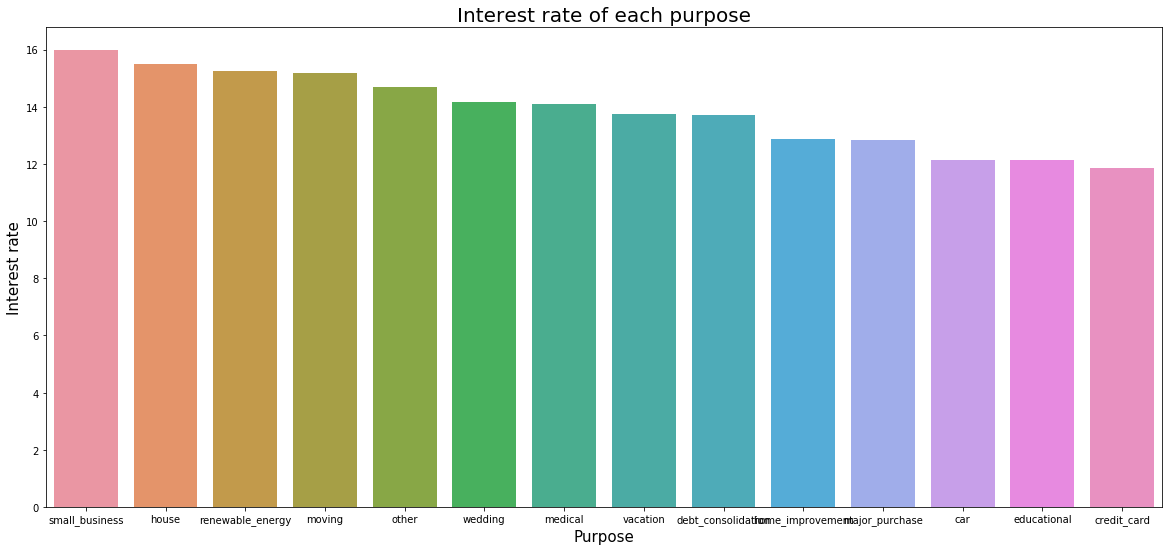

In [91]:
plt.figure(figsize=(20,30))
'''plt.subplot(311)'''
'''g1 = sns.barplot(x="purpose", y="loan_amount", data=df,
            estimator=lambda x: x.sum())
g1.set_xlabel("Purpose", fontsize=15)
g1.set_ylabel("Loan Amount", fontsize=15)
g1.set_title("Loan amount each purpose(Logarithm)", fontsize=20)'''

plt.subplot(312)
test = df.groupby(["purpose"], as_index=False).interest_rate.mean()
test.sort_values(by='interest_rate', ascending=False, inplace=True)
g2 = sns.barplot(x="purpose", y="interest_rate", data=test)
g2.set_xlabel("Purpose", fontsize=15)
g2.set_ylabel("Interest rate", fontsize=15)
g2.set_title("Interest rate of each purpose", fontsize=20)
'''
plt.subplot(313)
g3 = sns.barplot(x="purpose", y="loan_amount", hue="loan_condition", data=df,
            estimator=lambda x: np.log(x.sum()))
g3.set_xlabel("Purpose", fontsize=15)
g3.set_ylabel("Interest rate(Logarithm)", fontsize=15)
g3.set_title("Loan condition of each purpose (Logarithm)", fontsize=20)'''

In [90]:
test = df.groupby(["purpose"], as_index=False).interest_rate.mean() # 重新
test.sort_values(by='interest_rate', ascending=False, inplace=True)

# Verification status

In [196]:
df['verification_status'].value_counts()

Source Verified    518581
Verified           419316
Not Verified       403072
Name: verification_status, dtype: int64

In [226]:
test = df.groupby(['verification_status', 'loan_condition'], as_index=False).loan_amount.count()

In [235]:
a=0
test["proportion"]=None
for i in test['verification_status']:
    test["proportion"][a]= test["loan_amount"][a]/test.loan_amount[test["verification_status"]==i].sum()
    a += 1

C:\Users\HASEE\Anaconda3\envs\Year 3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [238]:
test

,verification_status,loan_condition,loan_amount,proportion
0,Not Verified,Bad Loan,67248,0.166839
1,Not Verified,Good Loan,335824,0.833161
2,Source Verified,Bad Loan,121024,0.233375
3,Source Verified,Good Loan,397557,0.766625
4,Verified,Bad Loan,108761,0.259377
5,Verified,Good Loan,310555,0.740623


(0, 0.9164774531597333)

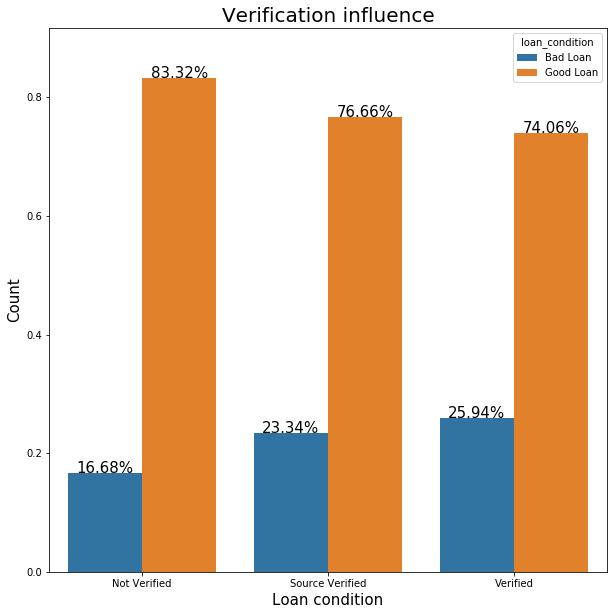

In [240]:
plt.figure(figsize=(10,10))

g1 = sns.barplot(x="verification_status", y = "proportion", hue="loan_condition", data=test)
g1.set_xlabel("Loan condition", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
g1.set_title("Verification influence", fontsize=20)
sizes=[]
for i in g1.patches:
    height = i.get_height()
    sizes.append(height)
    g1.text(i.get_x()+i.get_width()/2.,
            height,
            '{:1.2f}%'.format(height*100),
            ha="center", fontsize=15) 
g1.set_ylim(0, max(sizes) * 1.10)

Text(0.5, 1.0, 'Interest Rates by Verification status')

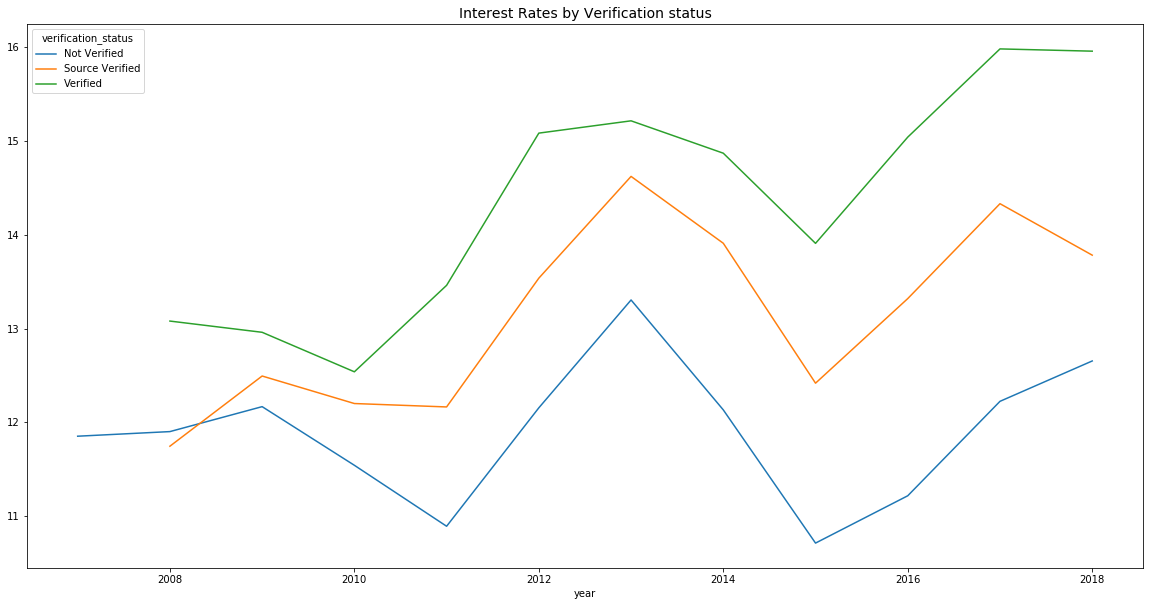

In [243]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)

by_inc = df.groupby(['year', 'verification_status']).interest_rate.mean()
by_inc.unstack().plot(ax=ax1)
ax1.set_title('Interest Rates by Verification status', fontsize=14)

# Prepare data for Modeling

In [2]:
data = pd.read_csv(
    'accepted_2007_to_2018Q4.csv',
    parse_dates=['issue_d'], infer_datetime_format=True)
data.head()

C:\Users\HASEE\Anaconda3\envs\Year 3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,2015-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,2015-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,N

While the loan status is current, the transaction is not completed yet. Thus we cannot infer from the status that it is good loan or bad loan. It would be better if we remove the "Current" data.

In [3]:
data.drop(data[data.loan_status == "Current"].index, inplace=True)

There are some features in the dictionary that do not match the features in our dataset, so we try to match them and choose the intersection of these features.

In [5]:
browse_notes = pd.read_excel('LCDataDictionary.xlsx',
                             sheet_name=1)
browse_notes.head()

,BrowseNotesFile,Description
0,acceptD,The date which the borrower accepted the offer
1,accNowDelinq,The number of accounts on which the borrower i...
2,accOpenPast24Mths,Number of trades opened in past 24 months.
3,addrState,The state provided by the borrower in the loan...
4,all_util,Balance to credit limit on all trades


In [6]:
browse_feat = browse_notes['BrowseNotesFile'].dropna().values
browse_feat = [re.sub('(?<![0-9_])(?=[A-Z0-9])', '_', x).lower().strip() for x in browse_feat]

In [7]:
data_feat = data.columns.values
np.setdiff1d(browse_feat, data_feat) #in browse_feature but not in data_feature

array(['accept_d', 'credit_pull_d', 'effective_int_rate', 'exp_d',
       'exp_default_rate', 'ils_exp_d', 'is_inc_v', 'list_d', 'msa',
       'mths_since_most_recent_inq', 'mths_since_oldest_il_open',
       'mths_since_recent_loan_delinq', 'review_status',
       'review_status_d', 'service_fee_rate', 'verified_status_joint'],
      dtype='<U35')

In [8]:
np.setdiff1d(data_feat, browse_feat) #in data_feature but not in browse_feature

array(['collection_recovery_fee', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'deferral_term', 'funded_amnt_inv',
       'hardship_amount', 'hardship_dpd', 'hardship_end_date',
       'hardship_flag', 'hardship_last_payment_amount', 'hardship_length',
       'hardship_loan_status', 'hardship_payoff_balance_amount',
       'hardship_reason', 'hardship_start_date', 'hardship_status',
       'hardship_type', 'issue_d', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt',
       'last_pymnt_d', 'loan_status', 'mo_sin_old_il_acct',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
       'next_pymnt_d', 'orig_projected_additional_accrued_interest',
       'out_prncp', 'out_prncp_inv', 'payment_plan_start_date',
       'policy_code', 'pymnt_plan', 'recoveries', 'settlement_amount',
       'settlement_date', 'settlement_percentage', 'settlement_status',
       'settlement_term', 'total_pymnt', 'total_pymnt_inv',
       'total

We unify the features that have different spellings in the two files, and select features that exist in both files as our variables.

In [9]:
wrong = ['is_inc_v', 'mths_since_most_recent_inq', 'mths_since_oldest_il_open',
         'mths_since_recent_loan_delinq', 'verified_status_joint']
correct = ['verification_status', 'mths_since_recent_inq', 'mo_sin_old_il_acct',
           'mths_since_recent_bc_dlq', 'verification_status_joint']

browse_feat = np.setdiff1d(browse_feat, wrong)
browse_feat = np.append(browse_feat, correct)
avail_feat = np.intersect1d(browse_feat, data_feat)
X = data[avail_feat].copy()
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1382384 entries, 0 to 2260700
Columns: 109 entries, acc_now_delinq to zip_code
dtypes: float64(89), object(20)
memory usage: 1.1+ GB


### Categorical Features

We tackle with the categorical features, transform them into other types, and delete the irrelevant features.

In [10]:
X.select_dtypes('object').head()

,addr_state,application_type,desc,disbursement_method,earliest_cr_line,emp_length,emp_title,grade,home_ownership,id,initial_list_status,purpose,sec_app_earliest_cr_line,sub_grade,term,title,url,verification_status,verification_status_joint,zip_code
0,PA,Individual,NaN,Cash,Aug-2003,10+ years,leadman,C,MORTGAGE,68407277,w,debt_consolidation,NaN,C4,36 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Not Verified,NaN,190xx
1,SD,Individual,NaN,Cash,Dec-1999,10+ years,Engineer,C,MORTGAGE,68355089,w,small_business,NaN,C1,36 months,Business,https://lendingclub.com/browse/loanDetail.acti...,Not Verified,NaN,577xx
2,IL,Joint App,NaN,Cash,Aug-2000,10+ years,truck driver,B,MORTGAGE,68341763,w,home_improvement,NaN,B4,60 months,NaN,https://lendingclub.com/browse/loanDetail.acti...,Not Verified,Not Verified,605xx
4,PA,Individual,NaN,Cash,Jun-1998,3 years,Contract Specialist,F,MORTGAGE,68476807,w,major_purchase,NaN,F1,60 months,Major purchase,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,174xx
5,GA,Individual,NaN,Cash,Oct-1987,4 years,Veterinary Tecnician,C,RENT,68426831,w,debt_consolidation,NaN,C3,36 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,300xx


The features `earliest_cr_line` and `sec_app_earliest_cr_line` are diverted into datetime and will later be transformed into numeric type in the model.

In [11]:
X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)
X['sec_app_earliest_cr_line'] = pd.to_datetime(X['sec_app_earliest_cr_line'], infer_datetime_format=True)

To transform the feature `emp_length` into float, we change '< 1 year' to '0 years' , '10+ years' to '11 years'.

In [12]:
X['emp_length'] = X['emp_length'].replace({'< 1 year': '0 years', '10+ years': '11 years'})
X['emp_length'] = X['emp_length'].str.extract('(\d+)').astype('float')

### Missing values

Below shows the ratio of missing values contributing to all the rows.

In [13]:
nan_mean = X.isna().mean()
nan_mean.sort_values()

id                                     0.000000
installment                            0.000024
disbursement_method                    0.000024
int_rate                               0.000024
loan_amnt                              0.000024
home_ownership                         0.000024
fico_range_low                         0.000024
purpose                                0.000024
initial_list_status                    0.000024
funded_amnt                            0.000024
term                                   0.000024
application_type                       0.000024
grade                                  0.000024
fico_range_high                        0.000024
url                                    0.000024
addr_state                             0.000024
verification_status                    0.000024
sub_grade                              0.000024
revol_bal                              0.000024
zip_code                               0.000025
annual_inc                             0

Then we remove the columns that are completely empty.

In [14]:
X = X.drop(['desc', 'member_id'], axis=1, errors='ignore')

To predict strictly, we use different methods to fill the values. The missing values of categorical features could be filled with an empty string.
The missing values of some numeric features should be filled with the maximum value of the column, while others are filled with the minimum.

In [15]:
cat_feature=['emp_title', 'verification_status_joint']
num_feature_max=['bc_open_to_buy', 'mo_sin_old_il_acct', 'mths_since_last_delinq',
               'mths_since_last_major_derog', 'mths_since_last_record',
               'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
               'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
               'pct_tl_nvr_dlq','sec_app_mths_since_last_major_derog']
num_feature_min=np.setdiff1d(X.columns.values, np.append(cat_feature, num_feature_max))

X[cat_feature] = X[cat_feature].fillna('')
X[num_feature_max] = X[num_feature_max].fillna(X[num_feature_max].max())
X[num_feature_min] = X[num_feature_min].fillna(X[num_feature_min].min())

### Multicollinearity

Afterwards, let's deal with multicollinearity. We write a function to return the correlation coefficients of pairs of features and remove one of them who have the high correlation coefficients.

In [16]:
num_feat = X.select_dtypes('number').columns.values
X[num_feat].nunique().sort_values()

num_tl_30dpd                                5
num_tl_120dpd_2m                            6
sec_app_inq_last_6mths                      7
acc_now_delinq                              8
emp_length                                 11
chargeoff_within_12_mths                   11
sec_app_collections_12_mths_ex_med         12
pub_rec_bankruptcies                       12
collections_12_mths_ex_med                 15
sec_app_chargeoff_within_12_mths           15
sec_app_mort_acc                           18
open_acc_6m                                19
open_il_12m                                19
mths_since_recent_inq                      26
open_rv_12m                                27
inq_last_6mths                             28
num_tl_90g_dpd_24m                         30
inq_fi                                     30
open_il_24m                                31
delinq_2yrs                                32
num_tl_op_past_12m                         32
num_actv_bc_tl                    

The features `num_tl_30dpd` and `num_tl_120dpd_2m` are rather constant that can be remove from our dataset. `id` value is unique to every row, thus we remove it as well to get rid of overfitting.

In [17]:
X = X.drop(['id','num_tl_30dpd','num_tl_120dpd_2m'], axis=1, errors='ignore')

We write a function to return the Pearson correlation coefficients of numeric features.

In [18]:
def corr_p(x,X):
    comb = np.array(list(combinations(x, 2)))
    corr = np.array([])
    for i in comb:
        corrval = pearsonr(X[i[0]], X[i[1]])[0]
        corr = np.append(corr, corrval)
    return comb,corr

In [22]:
X1=X[0:200000]

In [24]:
num_feat = X1.select_dtypes('number').columns.values
comb_num,corr_num = corr_p(num_feat,X)

C:\Users\HASEE\Anaconda3\envs\Year 3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [25]:
high_corr_num = comb_num[np.abs(corr_num) >= 0.9]
high_corr_num

C:\Users\HASEE\Anaconda3\envs\Year 3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


array([['all_util', 'il_util'],
       ['all_util', 'mths_since_rcnt_il'],
       ['fico_range_high', 'fico_range_low'],
       ['funded_amnt', 'installment'],
       ['funded_amnt', 'loan_amnt'],
       ['il_util', 'mths_since_rcnt_il'],
       ['installment', 'loan_amnt'],
       ['num_actv_rev_tl', 'num_rev_tl_bal_gt_0'],
       ['num_sats', 'open_acc'],
       ['tot_cur_bal', 'tot_hi_cred_lim']], dtype='<U35')

In [26]:
X = X.drop(np.unique(high_corr_num[:, 0]), axis=1, errors='ignore')

In [27]:
cat_feat = X.select_dtypes('object').columns.values
X[cat_feat].nunique().sort_values()

application_type                   2
disbursement_method                2
initial_list_status                2
term                               2
verification_status                3
verification_status_joint          4
home_ownership                     6
grade                              7
purpose                           14
sub_grade                         35
addr_state                        51
zip_code                         946
title                          63154
emp_title                     385455
url                          1382351
dtype: int64

In [28]:
X = X.drop(['url', 'emp_title'], axis=1, errors='ignore')

For categorical features, we import Cramer's V correlation coefficient： 
$$ V = \sqrt{ \frac{ \chi^2 }{ n (\text{min}(K_1, K_2) - 1) } } $$
Cramer's V is a way of calculating correlation in tables which have more than 2x2 rows and columns. It is used as post-test to determine strengths of association after chi-square has determined significance. 
We make a change as Pearson correlation coefficient does not apply to categorical features.

In [29]:
def corr_v(x,X):
    comb = np.array(list(combinations(x, 2)))
    corr = np.array([])
    for i in comb:
        table = pd.pivot_table(X, values='loan_amnt', index=i[0], columns=i[1], aggfunc='count').fillna(0)
        corrval = np.sqrt(chi2_contingency(table)[0] / (table.values.sum() * (np.min(table.shape) - 1) ) )
        corr = np.append(corr, corrval)
    return comb, corr

In [30]:
cat_feat = X.select_dtypes('object').columns.values
comb_cat,corr_cat = corr_v(cat_feat,X)

In [31]:
high_corr_cat = comb_cat[corr_cat >= 0.9]
high_corr_cat

array([['addr_state', 'zip_code'],
       ['application_type', 'verification_status_joint'],
       ['grade', 'sub_grade'],
       ['purpose', 'title']], dtype='<U25')

In [32]:
X = X.drop(np.unique(high_corr_cat[:, 1]), axis=1, errors='ignore')

In [33]:
X.dropna(inplace = True)

We transform `grade` A-E into ordinal value, representing by number 1-5.

In [34]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
grade_encoded = ordinal_encoder.fit_transform(X[['grade']])
grade_encoded = np.array(grade_encoded)
X['grade_encoded'] = grade_encoded

In [35]:
X["loan_status"]=data['loan_status'].copy()[X.index]

# Model

In [36]:
data = X.copy()

In [3]:
data.shape

(1382351, 93)

In [4]:
data["Y"] = data["loan_status"].isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']).astype('int')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382351 entries, 0 to 1382350
Data columns (total 94 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   Unnamed: 0                           1382351 non-null  int64  
 1   acc_now_delinq                       1382351 non-null  float64
 2   acc_open_past_24mths                 1382351 non-null  float64
 3   addr_state                           1382351 non-null  object 
 4   annual_inc                           1382351 non-null  float64
 5   annual_inc_joint                     1382351 non-null  float64
 6   application_type                     1382351 non-null  object 
 7   avg_cur_bal                          1382351 non-null  float64
 8   bc_open_to_buy                       1382351 non-null  float64
 9   bc_util                              1382351 non-null  float64
 10  chargeoff_within_12_mths             1382351 non-null  float64
 11

In [8]:
Object_term = data.columns[(data.dtypes == 'object').values]
data = data.drop(Object_term, axis=1)

In [9]:
# Use a utility from sklearn to split and shuffle our dataset.
train_data, test_data = train_test_split(data, test_size=0.2)
train_data, val_data = train_test_split(train_data, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_data.pop('Y'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_data.pop('Y'))
test_labels = np.array(test_data.pop('Y'))

train_features = np.array(train_data)
val_features = np.array(val_data)
test_features = np.array(test_data)



In [10]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (884704,)
Validation labels shape: (221176,)
Test labels shape: (276471,)
Training features shape: (884704, 81)
Validation features shape: (221176, 81)
Test features shape: (276471, 81)


We import confusion matirx in our model to test the overall performance.

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='TP'),
      keras.metrics.FalsePositives(name='FP'),
      keras.metrics.TrueNegatives(name='TN'),
      keras.metrics.FalseNegatives(name='FN'), 
      keras.metrics.BinaryAccuracy(name='Accuracy'),
      keras.metrics.Precision(name='Precision'),
      keras.metrics.Recall(name='Recall'),
      keras.metrics.AUC(name='auc'),
]


model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid'),
    ])

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

In [12]:
model.layers[-1].bias.assign([0.0])
history = model.fit(
    train_features,
    train_labels,
#    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=1)

Train on 884704 samples, validate on 221176 samples
Epoch 1/20
884704/884704 [==============================] - 44s 49us/sample - loss: 0.4849 - TP: 679354.0000 - FP: 182770.0000 - TN: 11839.0000 - FN: 10741.0000 - Accuracy: 0.7813 - Precision: 0.7880 - Recall: 0.9844 - auc: 0.6997 - val_loss: 0.4744 - val_TP: 170447.0000 - val_FP: 45316.0000 - val_TN: 3261.0000 - val_FN: 2152.0000 - val_Accuracy: 0.7854 - val_Precision: 0.7900 - val_Recall: 0.9875 - val_auc: 0.7169 17s - loss: 0.4880 - TP: 358850.0000  - ETA: 9s - loss: 0.4861 - TP: 513157.0000 - FP: 138195.0000 - TN: 8824.0000 - FN: 8176.0000 - Accurac - ETA: 5s
Epoch 2/20
884704/884704 [==============================] - 41s 46us/sample - loss: 0.4811 - TP: 679576.0000 - FP: 181942.0000 - TN: 12667.0000 - FN: 10519.0000 - Accuracy: 0.7825 - Precision: 0.7888 - Recall: 0.9848 - auc: 0.7076 - val_loss: 0.4748 - val_TP: 171762.0000 - val_FP: 47016.0000 - val_TN: 1561.0000 - val_FN: 837.0000 - val_Accuracy: 0.7836 - val_Precision: 0.7851

In [14]:
def plot_loss(history, label, n):
    plt.figure(figsize=(12,8))
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'], color='r', label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'], color='b', label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

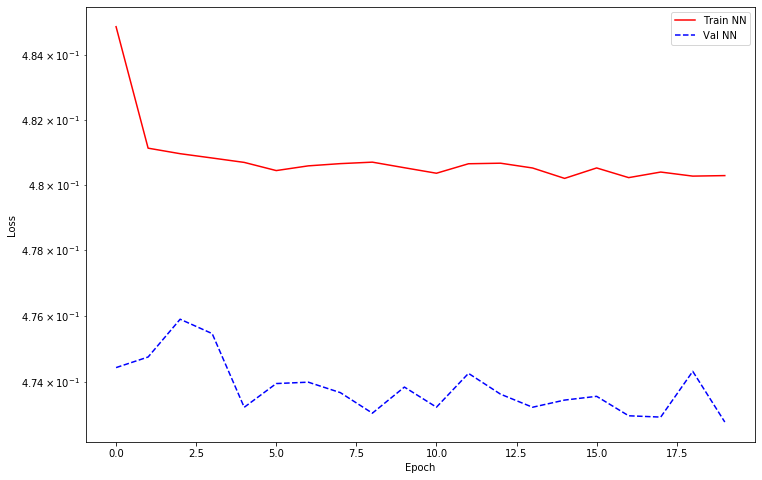

In [15]:
plot_loss(history, "NN", 0)

In [16]:
train_predictions_baseline = model.predict(train_features)
test_predictions_baseline = model.predict(test_features)

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve

Precision = $\frac{\text{true positives}}{\text{true positives} + \text{false positives}}$ <br>
Recall  = $\frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$ <br>

As we can infer from our fitting results, our model is persuing a better recall value. However, we would like to achieve higher precision as a lending club. We would rather predict a good loan bad instead of facing the risk that we approve the loan that is destined to be default.

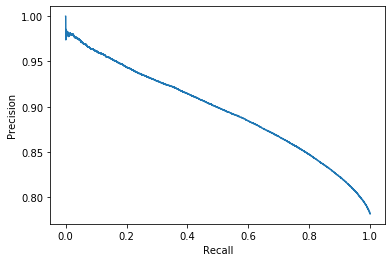

In [18]:
y_proba_val = model.predict(test_features)
p_val, r_val, t_val = precision_recall_curve(test_labels, y_proba_val)
plt.plot(r_val, p_val)
plt.xlabel('Recall')
plt.ylabel('Precision');

In [19]:
p_max = p_val[p_val != 1].max()
t_all = np.insert(t_val, 0, 0)
t_adj_val = t_all[p_val == p_max]
y_adj_val = (y_proba_val > t_adj_val).astype(int)
p_adj_val = precision_score(test_labels, y_adj_val)
print(f'Adjusted precision (validation): {p_adj_val:.3f}')

Adjusted precision (validation): 0.991


In [20]:
from statsmodels.stats.proportion import proportion_confint

In [21]:
n = y_adj_val.sum()
ci = proportion_confint(p_adj_val * n, n, alpha=0.05, method='wilson')
print(f'95% confidence interval for adjusted precision: [{ci[0]:.3f}, {ci[1]:.3f}]')

95% confidence interval for adjusted precision: [0.949, 0.998]


We write a funcion to adjust the threshold of determining to 0.97 and compare the result with the default threshold 0.5 of the model.

In [22]:
def plot_cm(labels, predictions, p=0.98):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    print("When threshold is 0.98")
    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
    print('Accuracy: ', (cm[0][0]+cm[1][1])/np.sum(cm[:]))
    print('recall: ', cm[1][1]/np.sum(cm[1]))
    print('Precise: ', cm[1][1]/(cm[0][1]+cm[1][1]))

276471/276471 [==============================] - 7s 26us/sample - loss: 0.4718 - TP: 212456.0000 - FP: 55472.0000 - TN: 4954.0000 - FN: 3589.0000 - Accuracy: 0.7864 - Precision: 0.7930 - Recall: 0.9834 - auc: 0.7193
when threshold is 0.5 
loss :  0.47179910154177096
TP :  212456.0
FP :  55472.0
TN :  4954.0
FN :  3589.0
Accuracy :  0.7863754
Precision :  0.7929593
Recall :  0.9833877
auc :  0.7193035
-----------------------------------------------
When threshold is 0.98
Legitimate Transactions Detected (True Negatives):  60398
Legitimate Transactions Incorrectly Detected (False Positives):  28
Fraudulent Transactions Missed (False Negatives):  214546
Fraudulent Transactions Detected (True Positives):  1499
Total Fraudulent Transactions:  216045
Accuracy:  0.22388243251552603
recall:  0.00693836932120623
Precise:  0.9816633922724296


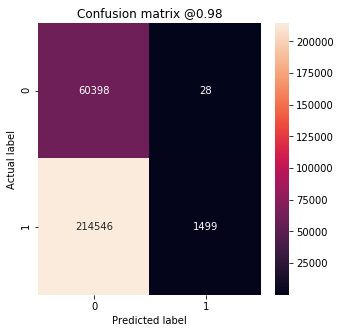

In [23]:
baseline_results = model.evaluate(test_features, test_labels, verbose=1)
print("when threshold is 0.5 ")
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print("-----------------------------------------------")
plot_cm(test_labels, test_predictions_baseline)

When threshold is 0.5, the accuracy and recall value is high while the precision is moderate. When threshold is 0.97, we give up high accuracy and recall but recieve a rather ideal precision.

In [24]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
#    plt.xlim([-0.5,20])
 #   plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

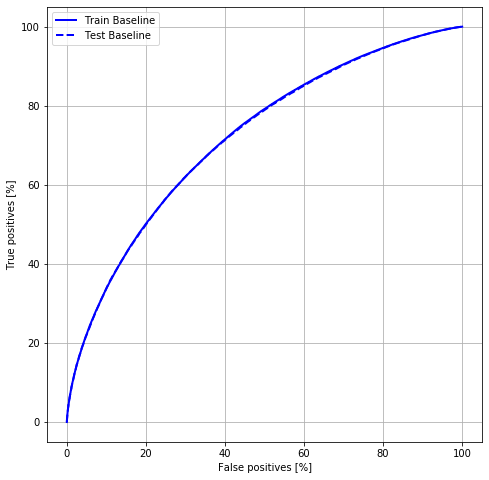

In [32]:
plt.figure(figsize=(12, 8))
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color='b')
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color='b', linestyle='--')
plt.legend(loc='best')

# Interest Rate Setting

We also aiming at constructing a model to see if we can generate interest rate for lenders automatically when data related are collected. 

In [33]:
data_for_interest = data.drop(["Y", "grade_encoded"], axis=1)

In [34]:
# Use a utility from sklearn to split and shuffle our dataset.
train_data, test_data = train_test_split(data_for_interest, test_size=0.2)
train_data, val_data = train_test_split(train_data, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_data.pop('int_rate'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_data.pop('int_rate'))
test_labels = np.array(test_data.pop('int_rate'))

train_features = np.array(train_data)
val_features = np.array(val_data)
test_features = np.array(test_data)

In [35]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (884704,)
Validation labels shape: (221176,)
Test labels shape: (276471,)
Training features shape: (884704, 79)
Validation features shape: (221176, 79)
Test features shape: (276471, 79)


In [36]:
def make_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(500, activation='relu', input_shape=(train_features.shape[-1],)),
        keras.layers.Dense(500, activation='relu'),
        keras.layers.Dense(1)
        ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=8e-4),
        loss="mse")

    return model

In [37]:
model = make_model()
#model.load_weights(initial_weights)
history = model.fit(
    val_features,
    val_labels,
#    batch_size=BATCH_SIZE,
    epochs=5,
    validation_data=(test_features, test_labels))

Train on 221176 samples, validate on 276471 samples
Epoch 1/5
221176/221176 [==============================] - 25s 115us/sample - loss: 13.6748 - val_loss: 12.8035
Epoch 2/5
221176/221176 [==============================] - 24s 109us/sample - loss: 12.6826 - val_loss: 12.4136
Epoch 3/5
221176/221176 [==============================] - 26s 115us/sample - loss: 12.3406 - val_loss: 12.1961
Epoch 4/5
221176/221176 [==============================] - 24s 109us/sample - loss: 12.1296 - val_loss: 12.2184
Epoch 5/5
221176/221176 [==============================] - 25s 113us/sample - loss: 11.9515 - val_loss: 12.2970


In [38]:
def plot_loss(history, label, n):
    plt.figure(figsize=(12,8))
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'], color='r', label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'], color='b', label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

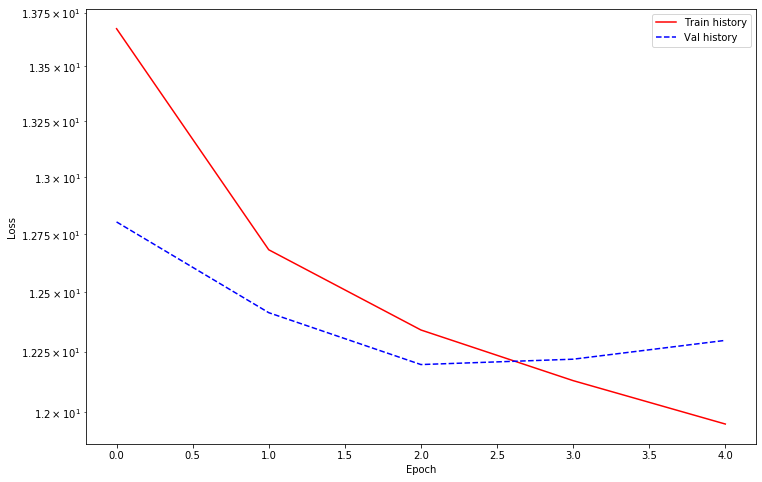

In [39]:
plot_loss(history, "history", 0)

In [40]:
model.predict(test_features[:10])

array([[12.329927],
       [ 5.770523],
       [13.029037],
       [17.858274],
       [17.32465 ],
       [15.009317],
       [10.781893],
       [ 9.028798],
       [11.143335],
       [12.819714]], dtype=float32)